# Preliminary exploration notebook

This notebook contains the following:
* Data loading and brief visualization
* Logistic regression
* Start work on CNN

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/') 

In [1]:
import os # work with system    
import cv2 # work with images
import numpy as np # arrays and numerical analysis  
import matplotlib.pyplot as plt # for data plots

import sklearn.linear_model # linear models
from sklearn.model_selection import train_test_split # data splitting
from sklearn import metrics # model evaluation

# os.chdir("drive/Shareddrives/Capstone 2023/Data/subset")


### set working directory in data folder
"""
assumes the following structure:
- MicrosoftSnakeAlgorithmProject
- Snakes-or-No-Snakes
    - *.ipynb (you are here)
"""
# os.chdir("../MicrosoftSnakeAlgorithmProject")
os.chdir("../subset") # small proof of concept subset

In [2]:
counter = 0 # if desired to break loop

# labels and filenames should match since they are appended in order
filenames = []
labels = []
# walk through all directories and files in current working directory
for root, dir, files in os.walk(os.getcwd()):
    
    for jpg in files:
        # if jpg file, then keep filename
        if ".JPG" in jpg:
            filenames.append(os.path.join(root, jpg))
            # for image files, create label based on path: 0 means empty, 1 means snake
            if "Empty" in root:
                labels.append(0)
            else:
                labels.append(1)

    counter += 1
    # if counter > 100: break

images = []
counter2 = 0
# read in each image as grayscale (each is a 2d array)
for img in filenames:
    images.append(cv2.imread(img, cv2.IMREAD_GRAYSCALE))

    counter2 += 1
    # if counter2 > 100: break

## Image display
Uncomment cell below if you want to see the pictures as loaded via opencv (cv2)

In [4]:
# # display image - will pop up in a separate window (seems to crash in colab)

# cv2.namedWindow("image", cv2.WINDOW_NORMAL)
# cv2.imshow("image", images[0])
# cv2.waitKey()

## Data processing

In [3]:
# convert to numpy arrays
image_arr = np.array(images)
label_arr = np.array(labels)
print(image_arr.shape)
print(label_arr.shape)

(45, 1536, 2048)
(45,)


In [6]:
# # scale data (currently broken)
# scaler = sklearn.preprocessing.MinMaxScaler()
# image_scaled = scaler.fit_transform(image_arr)

## Logistic Regression

In [7]:
# take colmean of each image to reduce features (for logistic regression)
image_reshape = image_arr.mean(axis=2)
print(image_reshape.shape)

(45, 1536)


In [8]:
# scale data 
scaler = sklearn.preprocessing.MinMaxScaler()
image_scaled = scaler.fit_transform(image_reshape)

In [9]:
# split data
x_train, x_test, y_train, y_test = train_test_split(
    image_reshape, label_arr, test_size = 0.4, random_state = 27)

In [10]:
## initialize logistic regression model
# sag: stochastic average gradient descent, chosen for speed
log_model = sklearn.linear_model.LogisticRegression(solver = "sag", max_iter = 10000)
# fit model on train data
log_model.fit(x_train, y_train)

LogisticRegression(max_iter=10000, solver='sag')

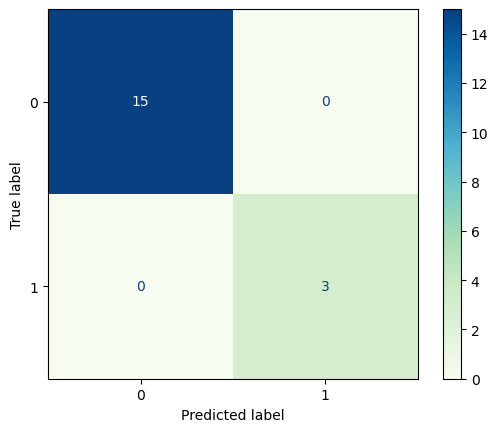

In [11]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(log_model, x_test, y_test,  cmap = "GnBu")

In [12]:
### model evaluation metrics 
predictions = log_model.predict(x_test)

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions)
print(precision)

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions, pos_label = 0)
print(specificity)

# no false positives means precision and specificity will be 100%

1.0
1.0
1.0
1.0


## CNN

In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [5]:
# resize images else will run out of memory
image_resized = []
for image in image_arr:
  image_resized.append(cv2.resize(image, (0, 0), fx = 0.3, fy = 0.3, interpolation = cv2.INTER_AREA))

In [6]:
# convert resized list into np array
image_arr_resized = np.array(image_resized)
print(image_arr_resized.shape)

(45, 461, 614)


In [7]:
# reshape for cnn
image_arr_reshaped = image_arr_resized.reshape([45, 461, 614, 1])
label_arr_reshaped = label_arr.reshape([45, 1])

In [13]:
# split data
x_train, x_test, y_train, y_test = train_test_split(
    image_arr_reshaped, label_arr_reshaped, test_size = 0.4, random_state = 27)

In [18]:
# create model (stock from keras documentation for now)
def build_model():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(461, 614, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    model.compile(
        optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics=['accuracy']
    )

    return model

In [19]:
# build the model
cnn_model = build_model()

In [20]:
# train the model
cnn_fit = cnn_model.fit(x_train, y_train, epochs=7, 
                        validation_data=(x_test, y_test))

Epoch 1/7
1/1 [==============================] - 19s 19s/step - loss: 4.4824 - accuracy: 0.3704 - val_loss: 740.1970 - val_accuracy: 0.8333
Epoch 2/7
1/1 [==============================] - 10s 10s/step - loss: 991.8575 - accuracy: 0.7778 - val_loss: 107.1493 - val_accuracy: 0.5000
Epoch 3/7
1/1 [==============================] - 7s 7s/step - loss: 101.7502 - accuracy: 0.6667 - val_loss: 109.2819 - val_accuracy: 0.9444
Epoch 4/7
1/1 [==============================] - 8s 8s/step - loss: 129.8338 - accuracy: 0.9259 - val_loss: 109.7417 - val_accuracy: 0.9444
Epoch 5/7
1/1 [==============================] - 7s 7s/step - loss: 131.0762 - accuracy: 0.9259 - val_loss: 54.4118 - val_accuracy: 0.9444
Epoch 6/7
1/1 [==============================] - 7s 7s/step - loss: 55.5266 - accuracy: 0.9259 - val_loss: 48.3338 - val_accuracy: 0.4444
Epoch 7/7
1/1 [==============================] - 7s 7s/step - loss: 37.0057 - accuracy: 0.7407 - val_loss: 31.4282 - val_accuracy: 0.9444


In [ ]:
# get class predictions
predictions_cnn = np.argmax(cnn_model.predict(x_test), axis = -1) 
print(predictions_cnn.shape)

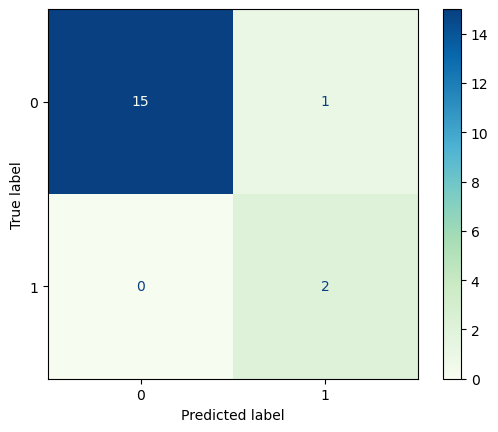

In [38]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(predictions_cnn, y_test, cmap = "GnBu")

In [39]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_cnn)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_cnn)
print(precision)

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_cnn)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_cnn, pos_label = 0)
print(specificity)

# no false positives means precision and specificity will be 100%

0.9444444444444444
1.0
0.6666666666666666
1.0


1/1 - 1s - loss: 31.4282 - accuracy: 0.9444 - 658ms/epoch - 658ms/step


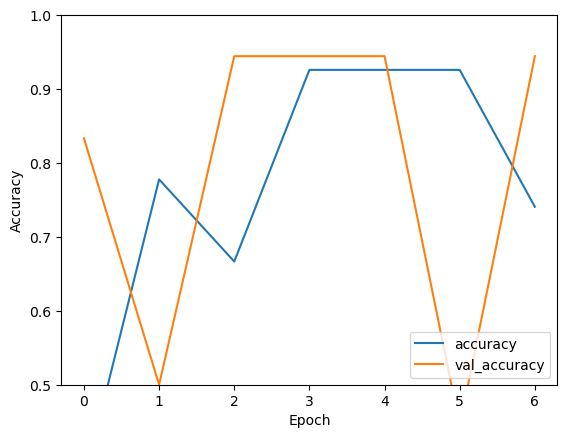

In [42]:
# plot accuracy across epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(x_test,  y_test, verbose=2)